In [1]:
import os
import sys

PROJECT_ROOT = os.path.join(os.path.abspath(os.path.dirname('./../../')), 'src')

sys.path.append(PROJECT_ROOT)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from config import Config
from feature_extraction_utils import *
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns

**Load data and features**

In [3]:
%%time
cfg = Config()
ds = DataSource(cfg)
ds.read_data()
ds.validation_split()

Reading groups_desc...
Reading train_x...
Reading test_x...
Reading train_target...
Reading test_target...
Validation split: by clientID
CPU times: user 24.6 s, sys: 4.86 s, total: 29.4 s
Wall time: 19.6 s


In [4]:
for dataset in ['train', 'valid']:
    # Global features
    path = adjust_path(cfg._cfg['global_features'][f'{dataset}_set'])
    ds.add_features(f'{dataset}_gf', path)
    # TS features
    path_dict = {k: adjust_path(v)
                 for k, v in cfg._cfg['ts_features'][f'{dataset}_set'].items()}
    for k, path in path_dict.items():
        ds.add_features(f'{dataset}_{k}', path)

In [5]:
print(ds)

Dataset: groups_desc, shape: (204, 2)
Dataset: train_x, shape: (21295142, 4)
Dataset: test_x, shape: (17667328, 4)
Dataset: train_target, shape: (24145, 2)
Dataset: test_target, shape: (20000, 1)
Dataset: valid_x, shape: (5155435, 4)
Dataset: valid_target, shape: (5855, 2)
Dataset: train_gf, shape: (24145, 708)
Dataset: train_small_group_seq, shape: (24145, 730)
Dataset: train_money_seq, shape: (24145, 730)
Dataset: valid_gf, shape: (5855, 708)
Dataset: valid_small_group_seq, shape: (5855, 730)
Dataset: valid_money_seq, shape: (5855, 730)


# Boosting

In [11]:
train_data_size = ds.get_data('train_target').shape[0]
train_mask = np.zeros(train_data_size)
train_mask[np.random.choice(train_data_size, int(train_data_size * 0.8), False)] = 1

In [104]:
from lightgbm import LGBMClassifier

cfg._cfg['lgbm_params'] = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'class_weight': 'balanced',
    'random_state': 42,
    'seed': 58,
    'bagging_seed': 3,
    'feature_fraction_seed': 2,
    'data_random_seed': 1,
    'verbose': -1,
    'silent': True    
}

lgbm_model = LGBMClassifier(**cfg._cfg['lgbm_params'])

In [105]:
X_train_valid, y_train_valid = ds.get_data('train_gf'), ds.get_data('train_target').bins

X_train, y_train = X_train_valid[train_mask == 1], y_train_valid[train_mask == 1]
X_valid, y_valid = X_train_valid[train_mask == 0], y_train_valid[train_mask == 0]

print(X_train.shape, X_valid.shape)

(19316, 708) (4829, 708)


In [106]:
lgbm_model.fit(X_train, y_train)

y_pred_lgbm_train = lgbm_model.predict(X_train)
y_pred_lgbm_valid = lgbm_model.predict(X_valid)

print(f"Train acc: {(y_train == y_pred_lgbm_train).mean()}")
print(f"Valid acc: {(y_valid == y_pred_lgbm_valid).mean()}")

Train acc: 0.9219300062124663
Valid acc: 0.6204183060675088


In [23]:
from sklearn.externals import joblib

joblib.dump(lgbm_model, adjust_path('models/lgbm_model.pkl'));

# FC

In [65]:
from keras.layers import *
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l1, l2

def get_model_v1():
    input_ = Input(shape = (708,))
    x = Dense(64, activation='relu')(input_)
    x = Dense(4, activation='softmax')(x)

    return Model(input_, x)

model = get_model_v1()
model_name = adjust_path('models/logs/fc_model_v1')

model.compile(optimizer = Adam(lr=1e-3),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=20,
    shuffle=True,
    callbacks=[
        CSVLogger(f'{model_name}.csv'),
        ModelCheckpoint(f'{model_name}.h5', save_best_only=True),
        #EarlyStopping(patience=3)
    ])

Train on 19316 samples, validate on 4829 samples
Epoch 1/20
19316/19316 [==============================] - 2s 86us/step - loss: 290.0978 - accuracy: 0.4390 - val_loss: 114.3021 - val_accuracy: 0.4477
Epoch 2/20
19316/19316 [==============================] - 2s 79us/step - loss: 110.4687 - accuracy: 0.4634 - val_loss: 82.2888 - val_accuracy: 0.4191
Epoch 3/20
19316/19316 [==============================] - 2s 80us/step - loss: 56.1850 - accuracy: 0.4710 - val_loss: 47.2940 - val_accuracy: 0.4610
Epoch 4/20
19316/19316 [==============================] - 2s 80us/step - loss: 34.2661 - accuracy: 0.4803 - val_loss: 34.6897 - val_accuracy: 0.3953
Epoch 5/20
19316/19316 [==============================] - 2s 79us/step - loss: 19.5494 - accuracy: 0.4814 - val_loss: 28.2545 - val_accuracy: 0.4763
Epoch 6/20
19316/19316 [==============================] - 2s 79us/step - loss: 13.8682 - accuracy: 0.4718 - val_loss: 14.6848 - val_accuracy: 0.4133
Epoch 7/20
19316/19316 [==============================

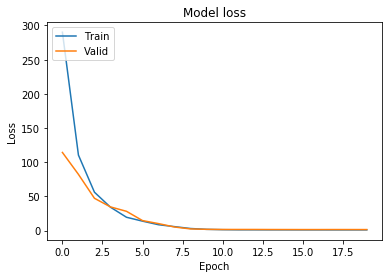

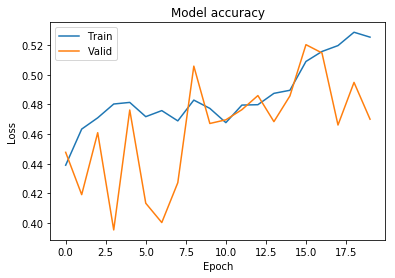

In [67]:
from matplotlib import pyplot as plt

def plot_history(history, metric='loss'):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])

    plt.title(f'Model {metric}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
plot_history(history)
plot_history(history, 'accuracy')

**Scale input**

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [73]:
model = get_model_v1()
model_name = adjust_path('models/logs/fc_model_v2_scaled_input')

model.compile(optimizer = Adam(lr=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train, 
    validation_data=(X_valid_scaled, y_valid),
    batch_size=16,
    epochs=20,
    shuffle=True,
    callbacks=[
        CSVLogger(f'{model_name}.csv'),
        ModelCheckpoint(f'{model_name}.h5', save_best_only=True),
        #EarlyStopping(patience=3)
    ])

Train on 19316 samples, validate on 4829 samples
Epoch 1/20
19316/19316 [==============================] - 3s 147us/step - loss: 1.1775 - accuracy: 0.4902 - val_loss: 1.0514 - val_accuracy: 0.5370
Epoch 2/20
19316/19316 [==============================] - 3s 142us/step - loss: 0.9910 - accuracy: 0.5649 - val_loss: 0.9992 - val_accuracy: 0.5550
Epoch 3/20
19316/19316 [==============================] - 3s 143us/step - loss: 0.9344 - accuracy: 0.5846 - val_loss: 0.9757 - val_accuracy: 0.5689
Epoch 4/20
19316/19316 [==============================] - 3s 142us/step - loss: 0.9037 - accuracy: 0.6023 - val_loss: 0.9657 - val_accuracy: 0.5753
Epoch 5/20
19316/19316 [==============================] - 3s 139us/step - loss: 0.8824 - accuracy: 0.6106 - val_loss: 0.9621 - val_accuracy: 0.5776
Epoch 6/20
19316/19316 [==============================] - 3s 141us/step - loss: 0.8664 - accuracy: 0.6210 - val_loss: 0.9657 - val_accuracy: 0.5778
Epoch 7/20
19316/19316 [==============================] - 3s 13

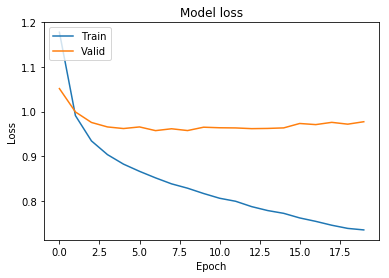

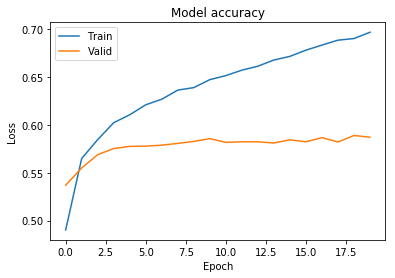

In [74]:
plot_history(history)
plot_history(history, 'accuracy')

# RNN

In [94]:
X_money_seq_train_valid, X_sgs_train_valid, y_train_valid = \
    ds.get_data('train_small_group_seq'), ds.get_data('train_money_seq'), ds.get_data('train_target').bins

X_m_train, X_sgs_train, y_train = \
    X_money_seq_train_valid[train_mask == 1], X_sgs_train_valid[train_mask == 1], y_train_valid[train_mask == 1]
X_m_valid, X_sgs_valid, y_valid = \
    X_money_seq_train_valid[train_mask == 0], X_sgs_train_valid[train_mask == 0], y_train_valid[train_mask == 0]

print(X_m_train.shape, X_sgs_train.shape, y_train.shape)
print(X_m_valid.shape, X_sgs_valid.shape, y_valid.shape)

(19316, 730) (19316, 730) (19316,)
(4829, 730) (4829, 730) (4829,)


**Split into 2 parts in order to speed up RNN**

In [95]:
X_m_train_y1, X_m_train_y2 = X_m_train[:, :365], X_m_train[:, 365:]
X_sgs_train_y1, X_sgs_train_y2 = X_sgs_train[:, :365], X_sgs_train[:, 365:]
X_m_valid_y1, X_m_valid_y2 = X_m_valid[:, :365], X_m_valid[:, 365:]
X_sgs_valid_y1, X_sgs_valid_y2 = X_sgs_valid[:, :365], X_sgs_valid[:, 365:]

In [99]:
from keras.backend import expand_dims

def get_model_rnn():
    cat_input_y1 = Input(shape = (365,))
    cat_input_y2 = Input(shape = (365,))
    money_input_y1 = Input(shape = (365,))
    money_input_y2 = Input(shape = (365,))
    
    cat_emb = Embedding(205, 10)
    money_seq = Lambda(lambda x: expand_dims(x, -1))
    
    cat_emb_y1 = cat_emb(cat_input_y1)
    cat_emb_y2 = cat_emb(cat_input_y2)
    
    money_seq_y1 = money_seq(money_input_y1)
    money_seq_y2 = money_seq(money_input_y2)
    
    x_lstm = LSTM(30)
    
    x_y1 = Concatenate(axis=-1)([cat_emb_y1, money_seq_y1])
    x_y2 = Concatenate(axis=-1)([cat_emb_y2, money_seq_y2])
    
    x_y1 = x_lstm(x_y1)
    x_y2 = x_lstm(x_y2)
    
    x = Concatenate(axis=1)([x_y1, x_y2])
    #x = Flatten()([x])
    
    x = Dense(4, activation='softmax')(x)
    
    return Model(
        [cat_input_y1, cat_input_y2, money_input_y1, money_input_y2],
        x)

model = get_model_rnn()
model_name = adjust_path('models/logs/rnn_model_v1')

model.compile(optimizer = Adam(lr=1e-3),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 365)          0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           (None, 365)          0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           (None, 365)          0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           (None, 365)          0                                            
___________________________________________________________________________________________

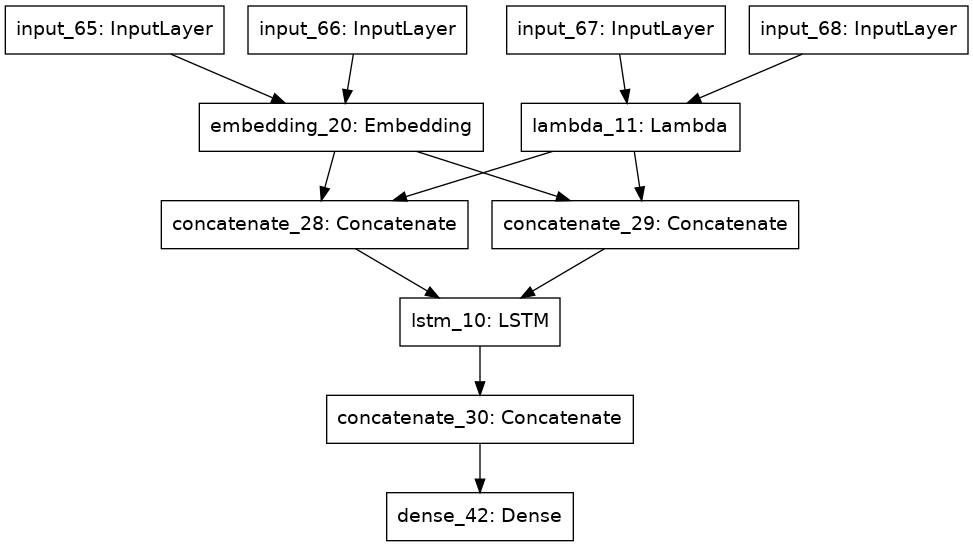

In [97]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [100]:
history = model.fit(
    [X_m_train_y1, X_m_train_y2, X_sgs_train_y1, X_sgs_train_y2], y_train, 
    validation_data=([X_m_valid_y1, X_m_valid_y2, X_sgs_valid_y1, X_sgs_valid_y2], y_valid),
    batch_size=16,
    epochs=20,
    shuffle=True,
    callbacks=[
        CSVLogger(f'{model_name}.csv'),
        ModelCheckpoint(f'{model_name}.h5', save_best_only=True),
        #EarlyStopping(patience=3)
    ])

Train on 19316 samples, validate on 4829 samples
Epoch 1/20
19316/19316 [==============================] - 303s 16ms/step - loss: 1.2613 - accuracy: 0.3923 - val_loss: 1.2842 - val_accuracy: 0.3837
Epoch 2/20
19316/19316 [==============================] - 289s 15ms/step - loss: 1.1493 - accuracy: 0.4589 - val_loss: 1.1162 - val_accuracy: 0.4800
Epoch 3/20
19316/19316 [==============================] - 286s 15ms/step - loss: 1.1051 - accuracy: 0.4872 - val_loss: 1.0966 - val_accuracy: 0.4808
Epoch 4/20
19316/19316 [==============================] - 268s 14ms/step - loss: 1.0576 - accuracy: 0.5171 - val_loss: 1.0804 - val_accuracy: 0.5057
Epoch 5/20
19316/19316 [==============================] - 264s 14ms/step - loss: 1.0191 - accuracy: 0.5379 - val_loss: 1.0349 - val_accuracy: 0.5299
Epoch 6/20
19316/19316 [==============================] - 265s 14ms/step - loss: 0.9932 - accuracy: 0.5470 - val_loss: 1.0089 - val_accuracy: 0.5413
Epoch 7/20
19316/19316 [==============================] -

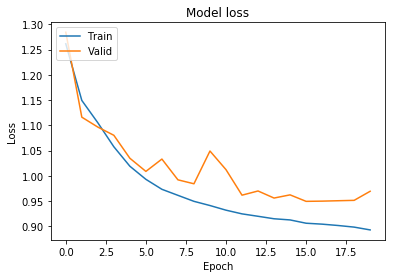

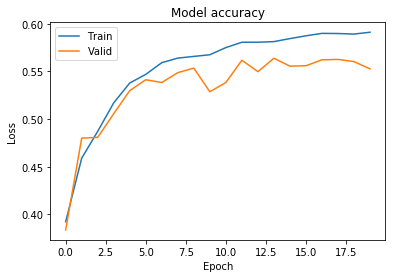

In [107]:
plot_history(history)
plot_history(history, 'accuracy')